# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
import os
import requests
import tweepy


## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
df_1 = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [4]:
print(r.text[:5000])

tweet_id	jpg_url	img_num	p1	p1_conf	p1_dog	p2	p2_conf	p2_dog	p3	p3_conf	p3_dog
666020888022790149	https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg	1	Welsh_springer_spaniel	0.465074	True	collie	0.156665	True	Shetland_sheepdog	0.0614285	True
666029285002620928	https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg	1	redbone	0.506826	True	miniature_pinscher	0.07419169999999999	True	Rhodesian_ridgeback	0.07201	True
666033412701032449	https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg	1	German_shepherd	0.596461	True	malinois	0.13858399999999998	True	bloodhound	0.11619700000000001	True
666044226329800704	https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg	1	Rhodesian_ridgeback	0.408143	True	redbone	0.360687	True	miniature_pinscher	0.222752	True
666049248165822465	https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg	1	miniature_pinscher	0.560311	True	Rottweiler	0.243682	True	Doberman	0.154629	True
666050758794694657	https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg	1	Bernese_mountain_dog	0.651137	True	English_spri

In [5]:
file = open('image-predictions.tsv', 'w')
file.write(r.text)
file.close()

In [6]:
df_2 = pd.read_csv('image-predictions.tsv', delim_whitespace = True)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
access_token = ""
access_secret = ""
consumer_key = ""
consumer_secret = ""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
with open('tweet-json.txt', 'a', encoding='utf8') as f:
    for tweet_id in df_1['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            continue

In [9]:
twitter_list = []

for line in open('tweet-json.txt', 'r'):
    twitter_data = json.loads(line)
    twitter_list.append({'tweet_id': twitter_data['id_str'],
                        'retweet_count': twitter_data['retweet_count'],
                        'favorite_count': twitter_data['favorite_count'],
                        'followers_count': twitter_data['user']['followers_count']})
    

In [10]:
df_3 = pd.DataFrame(twitter_list, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'followers_count']) 

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [11]:
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
df_1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
df_1.shape

(2356, 17)

In [15]:
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [16]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
df_2.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [18]:
df_2.shape

(2075, 12)

In [19]:
df_2.duplicated().sum()

0

In [20]:
df_3.head()

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,8853,39467,3200889
1,892177421306343426,6514,33819,3200889
2,891815181378084864,4328,25461,3200889
3,891689557279858688,8964,42908,3200889
4,891327558926688256,9774,41048,3200889


In [21]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id           2354 non-null object
retweet_count      2354 non-null int64
favorite_count     2354 non-null int64
followers_count    2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


In [22]:
df_3.describe()

,retweet_count,favorite_count,followers_count
count,2354.000000,2354.000000,2.354000e+03
mean,3164.797366,8080.968564,3.200942e+06
std,5284.770364,11814.771334,4.457302e+01
min,0.000000,0.000000,3.200799e+06
25%,624.500000,1415.000000,3.200898e+06
50%,1473.500000,3603.500000,3.200945e+06
75%,3652.000000,10122.250000,3.200953e+06
max,79515.000000,132810.000000,3.201018e+06


In [23]:
df_3.shape

(2354, 4)

In [24]:
df_1.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [25]:
df_1.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [26]:
df_1.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [27]:
df_1.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Lola          10
Tucker        10
Penny         10
Bo             9
Winston        9
Sadie          8
the            8
Buddy          7
an             7
Bailey         7
Daisy          7
Toby           7
Koda           6
Jack           6
Oscar          6
Dave           6
Jax            6
Stanley        6
Scout          6
Rusty          6
Milo           6
Leo            6
Bella          6
Oakley         5
            ... 
Yukon          1
Juckson        1
Tassy          1
Butters        1
Clifford       1
Acro           1
Mona           1
Andy           1
Anna           1
Rupert         1
Jessifer       1
Pilot          1
Jockson        1
Trevith        1
Alexander      1
Horace         1
Tom            1
Gilbert        1
Emma           1
Tango          1
Lupe           1
Sprout         1
Maks           1
Eugene         1
Torque         1
Mingus         1
Dex            1
Oreo          

### Quality issues
1. Keep original ratings only(no retweets)

2. The extracted rating numerators are wrong when they are decimals

3. Erroneous datatypes in columns 

4. Problem with dog names

5. Incorrect dog type

6. Remove unwanted columns in analysis

7. Some tweets includes hyperlinks

8. Source column is in HTML-formatted string, not a normal string

### Tidiness issues
1. Merging two table together

2. Combining the columns doggo, puppo, pupper, floofer into a single column

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [28]:
# Make copies of original pieces of data
df1_clean = df_1.copy()
df2_clean = df_2.copy()
df3_clean = df_3.copy()

### Issue #1: Keep original ratings only(no retweets) 

#### Define:  Delete retweets by filtering the NaN of retweeted_status_user_id


#### Code

In [29]:
df1_clean = df1_clean[pd.isnull(df1_clean['retweeted_status_user_id'])]

#### Test

In [30]:
print(sum(df1_clean.retweeted_status_user_id.value_counts()))

0


### Issue #2: The extracted rating numerators are wrong when they are decimals.

#### Define: Correct numerators with decimals, Change datatype and use regex to extract the ratings numerators again.

#### Code

In [31]:
df1_clean['rating_numerator'] = df1_clean['rating_numerator'].astype('float')

In [32]:
df1_clean['rating_numerator'] = df1_clean['text'].str.extract('(\d+\.*\d*\/\d+)', expand=False).str.split('/').str[0]


#### Test

In [33]:
print(df1_clean.rating_numerator.dtype)

object


In [34]:
df1_clean.loc[df1_clean['tweet_id'] == 883482846933004288, 'rating_numerator']

45    13.5
Name: rating_numerator, dtype: object

### Issue #3: Erroneous datatype fix


#### Define

Erroneous datatype fix, convert tweet_id to str in df1, df2 ,df3.

Convert timstamp to datetime and convert source to category datatype


#### Code

In [35]:
df1_clean.tweet_id = df1_clean.tweet_id.astype(str)
df2_clean.tweet_id = df2_clean.tweet_id.astype(str)
df3_clean.tweet_id = df3_clean.tweet_id.astype(str)

df1_clean.timestamp = pd.to_datetime(df1_clean.timestamp)

df1_clean.source = df1_clean.source.astype("category")

#### Test

In [36]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null category
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null object
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: category(1), datet

### Issue #4: Problem with dog names

#### Define 
 Incorrect dog names

#### Code

In [37]:
df1_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such', 'Canela', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl',
       'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty',
       'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven',
       'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante',
       'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash',
       'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie',
       'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha',
       'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jer

In [38]:
df1_clean['name'][df1_clean['name'].str.match('[a-z]+')] = 'None'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Test

In [39]:
df1_clean.name.value_counts()

None         784
Lucy          11
Charlie       11
Oliver        10
Cooper        10
Tucker         9
Penny          9
Sadie          8
Lola           8
Winston        8
Daisy          7
Toby           7
Stanley        6
Jax            6
Koda           6
Oscar          6
Bella          6
Bailey         6
Bo             6
Rusty          5
Bentley        5
Louis          5
Leo            5
Scout          5
Buddy          5
Dave           5
Chester        5
Milo           5
Derek          4
Winnie         4
            ... 
Lucky          1
Georgie        1
Dotsy          1
Nico           1
Grizz          1
Torque         1
Eugene         1
Maks           1
Herschel       1
Robin          1
Durg           1
Sailer         1
Lorelei        1
Andy           1
Rupert         1
Jessifer       1
Pilot          1
Jockson        1
Trevith        1
Sprout         1
Alexander      1
Horace         1
Tom            1
Paull          1
Gilbert        1
Anna           1
Emma           1
Scott         

### Issue #5: Incorrect dog stage

#### Define
Some dog with more than one stage

#### Code

In [40]:
df1_clean['add_all'] = df1_clean.doggo + df1_clean.floofer + df1_clean.pupper + df1_clean.puppo

In [41]:
df1_clean.add_all.value_counts()

NoneNoneNoneNone        1831
NoneNonepupperNone       224
doggoNoneNoneNone         75
NoneNoneNonepuppo         24
doggoNonepupperNone       10
NoneflooferNoneNone        9
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
Name: add_all, dtype: int64

In [42]:
def check_stages(archive):
    if archive['add_all'].count('None') == 2:
        return 'Multiple' 
    else:
        if archive['add_all'].count('doggo') == 1:
            return 'Doggo'
        elif archive['add_all'].count('floofer') == 1:
            return 'Floofer'
        elif archive['add_all'].count('pupper') == 1:
            return 'Pupper'
        elif archive['add_all'].count('puppo') == 1:
            return 'Puppo'
        else:
            return 'None'

df1_clean['dog_stage'] = df1_clean.apply(check_stages, axis=1)

#### Test

In [43]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null category
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null object
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
add_all                   

### Issue #6:  Remove columns not needed for analysis

#### Define
Remove columns not needed'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'

#### Code

In [44]:
df1_clean = df1_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                                            'retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls'], 1)

#### Test

In [45]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null category
text                  2175 non-null object
rating_numerator      2175 non-null object
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
add_all               2175 non-null object
dog_stage             2175 non-null object
dtypes: category(1), datetime64[ns](1), int64(1), object(10)
memory usage: 223.2+ KB


### Issue #7:   Some tweets includes hyperlinks

#### Define
 Remove hyperlinks in tweets.

#### Code

In [46]:
def htmlink(x):
        http_pos = x.find("http")
        if http_pos == -1:
            x = x
        else:
            x = x[:http_pos - 1]
        return x
    
df1_clean.text = df1_clean.text.apply(htmlink)

#### Test

In [47]:
for row in df1_clean.text[:20]:
    print(row)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek
Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek
Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below

When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10
This is Zoey. She doesn't want to be one of the scary shark

### Issue #8:   Source column is in HTML-formatted string, not a normal string

#### Define
 To clean the column into the correct data type

#### Code

In [48]:
df1_clean.source = df1_clean.source.str.extract('>([\w\W\s]*)<', expand=True)

#### Test

In [49]:
df1_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Tidiness Issue #1: Move twitter api table and image prediction table to twitter archive table.

#### Define:
Merge the tables to have clear picture

#### Code

In [50]:
df1_clean = pd.merge(left=df1_clean, right=df3_clean, how='left', on='tweet_id')
df1_clean = pd.merge(left=df1_clean, right=df2_clean, how='left', on='tweet_id')

#### Test

In [51]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 27 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null object
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
add_all               2175 non-null object
dog_stage             2175 non-null object
retweet_count         2175 non-null int64
favorite_count        2175 non-null int64
followers_count       2175 non-null int64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 

### Tidiness Issue #2 : Combining the columns doggo, puppo, pupper, floofer into a single column

#### Define
Combining the columns doggo, puppo, pupper, floofer into a single column

#### Code

In [52]:
df1_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'add_all'], axis=1, inplace=True)

In [53]:
df1_clean.dog_stage = df1_clean.dog_stage.astype('category')

#### Test

In [54]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null object
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null category
retweet_count         2175 non-null int64
favorite_count        2175 non-null int64
followers_count       2175 non-null int64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null object
p3                    1994 non-null object
p3_conf               19

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [55]:
df1_clean.to_csv('twitter_archive_master.csv', index=False)

In [56]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [57]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 22 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null object
retweet_count         2175 non-null int64
favorite_count        2175 non-null int64
followers_count       2175 non-null int64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null object
p3                    1994 non-null object
p3_conf               1994 non-nul

In [58]:
twitter_archive_master.tweet_id = twitter_archive_master.tweet_id.astype(str)
twitter_archive_master.dog_stage = twitter_archive_master.dog_stage.astype("category")
twitter_archive_master[['rating_numerator', 'rating_denominator']] = twitter_archive_master[['rating_numerator', 'rating_denominator']].astype(float)
twitter_archive_master[['retweet_count', 'favorite_count', 'followers_count']] = twitter_archive_master[['retweet_count', 'favorite_count', 'followers_count']].astype(int)
twitter_archive_master.source = twitter_archive_master.source.astype("category")
twitter_archive_master.timestamp = pd.to_datetime(twitter_archive_master.timestamp)

In [59]:
 twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 22 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null category
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
dog_stage             2175 non-null category
retweet_count         2175 non-null int64
favorite_count        2175 non-null int64
followers_count       2175 non-null int64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog                1994 non-null object
p3                    1994 non-null object
p3_conf            

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1. What is the most favour Twitter Source?

2. What is the most popular dog name?

3. Is there a correlation between Favorite and Retweet?

#### 1.  What is the most favour Twitter Source?

In [60]:
source = twitter_archive_master['source'].value_counts()
source

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

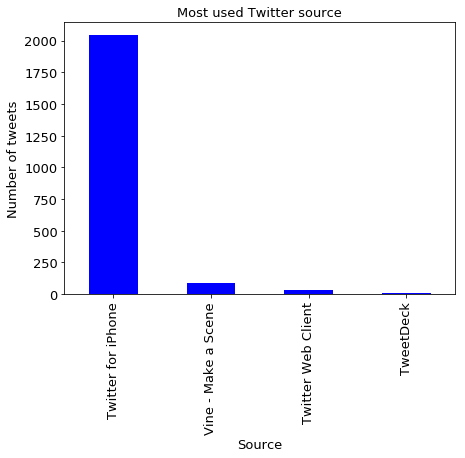

In [61]:
#plot
g_bar = source.plot.bar(color = 'blue', fontsize = 13)

#figure size(width, height)
g_bar.figure.set_size_inches(7, 5);

#Add labels
plt.title('Most used Twitter source', color = 'black', fontsize = '13')
plt.xlabel('Source', color = 'black', fontsize = '13')
plt.ylabel('Number of tweets', color = 'black', fontsize = '13'); 

The most favour twitter source is iphone. Its show the trend of the device that people using.

#### 2.  What is the most popular dog name?

In [62]:
pname = twitter_archive_master.name.value_counts()[1:10]

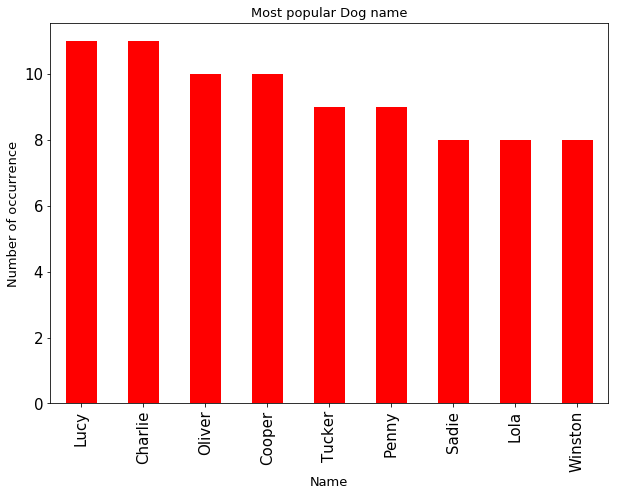

In [63]:
#plot
g_bar = pname.plot.bar(color = 'red', fontsize = 15)

#figure size(width, height)
g_bar.figure.set_size_inches(10, 7);

#Add labels
plt.title('Most popular Dog name', color = 'black', fontsize = '13')
plt.xlabel('Name', color = 'black', fontsize = '13')
plt.ylabel('Number of occurrence', color = 'black', fontsize = '13');

The most used dog name is charlie. And the second are Oliver, Cooper and Lucy.

#### 3.  Is there a correlation between Favorite and Retweet?

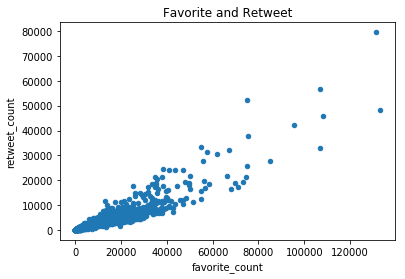

In [64]:
twitter_archive_master.plot(x='favorite_count', y='retweet_count', kind='scatter', title = 'Favorite and Retweet');


In [65]:
twitter_archive_master['favorite_count'].corr(twitter_archive_master['retweet_count']) 

0.91173165335641071

 The scatter plot shows there is a positive correlation between favorite and Retweet.